In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.style.use("dark_background")
%matplotlib inline

In [2]:
sys.path.append("../../src")
from models import MLP
from data import gen_rnd_ds
from losses import LinearClassification, SquaredClassification
from block_analysis import *
from derivation import hessian, jacobian

## Params

In [3]:
# Model
mode = "relu"
bias = False
nlayer = 2
inp_dim = 2
out_dim = 3
hid_dim = 4

# Data parameters
nsamp = 1000
inp_mean = 0
inp_var = 1


# Others
device = 0
lr = 1

In [4]:
from derivation import infer_layer_idx

def kronecker_product(t1, t2):
    """
    """
    t1_height, t1_width = t1.size()
    t2_height, t2_width = t2.size()
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

def H22(model, x):
    """
    """
    out_dim = model.out.fc.weight.shape[0]
    with torch.no_grad():
        wx = model.l1(x)
        wxxw = wx.t().mm(wx)
        Id = torch.eye(out_dim).cuda()
        return kronecker_product(Id, wxxw)
    
def H11(model, x):
    """
    """
    with torch.no_grad():
        xx = x.t().mm(x)
        
        act = model.l1.act.last_msk
        act = act.t().mm(act)
        w2 = model.out.fc.weight
        ww2 = w2.t().mm(w2)
        return kronecker_product(ww2*act, xx)
        
def H12(model, x, y, loss="linear"):
    """
    """    
    hlin = Hij_linear(model, x, y)
    if loss == "linear":
        return hlin
    else:
        return hlin + Hij_squared(model, x)

def Hij_linear(model, x, y):
    """
    """
    with torch.no_grad():
        xy = get_xy(x, y, loss_fn)
        ks = [kronecker_product(torch.eye(10).cuda(), xy[:,i:i+1]) for i in range(xy.shape[1])]
        return torch.cat(ks, 1)
        
def Hij_squared(model, x):
    """
    """
    B = model.out.fc.weight.t()
    shared_dim = B.shape[0]
    out_dim = B.shape[1]
    with torch.no_grad():
        # Asymetric path
        Axxt = model.l1(x.t().mm(x))
        asympath = kronecker_product(B, Axxt)
        # Symetric path
        out = x.t().mm(model(x))
        sympath = torch.cat([kronecker_product(torch.eye(shared_dim, shared_dim).cuda(), out[:,i][:,None]) \
                             for i in range(out_dim)], 1)
        return asympath + sympath
    
def get_block(H, model, i, j):
    """
    """
    idx = infer_layer_idx(model.parameters())
    return H[idx[i]:idx[i+1], idx[j]:idx[j+1]]

def get_xy(x, y, loss_fn):
    """
    """
    Y = loss_fn.lookup[y.squeeze()]
    return -x.t().mm(Y)

In [5]:
import torch.nn as nn

class Activation(nn.Module):
    def __init__(self, mode="linear"):
        """
        """
        super().__init__()
        assert mode in ["relu", "linear"]
        self.mode = mode
        self.last_msk = None
        
    def set_mode(self, mode):
        """
        """
        assert mode in ["relu", "replay", "linear"]
        self.mode=mode
        
    def forward(self, x):
        """
        """
        if self.mode=="relu":
            msk = (x>0).detach().to(x.dtype)
            self.last_msk = msk
            self.last_inp = x
            return x*msk
        
        elif self.mode=="replay":
            assert self.mode=="relu" and self.last_msk is not None
            return x*self.last_msk
        else:
            return x

class FC(nn.Module):
    def __init__(self, inp, out, bias=False, mode="linear"):
        """
        """
        super().__init__()
        self.fc = nn.Linear(inp, out, bias=bias)
        self.act = Activation(mode)
        
    def forward(self, x):
        """
        """
        return self.act(self.fc(x))
        
class MLP(nn.Module):
    def __init__(self, inp, hid, out, nlayer, bias=False, mode="linear"):
        """
        """
        super().__init__()
        self.l1 = FC(inp, hid, bias=bias, mode=mode)
        self.layers = nn.Sequential(*[FC(hid, hid, bias=bias, mode=mode) \
                                      for i in range(max(0,nlayer-2))])
        self.out = FC(hid, out, bias=bias, mode="linear")
        
    def forward(self, x):
        """
        """
        return self.out(self.layers(self.l1(x)))
    
    def get_mode(self):
        """
        """
        return next(self._activations()).mode
    
    def set_mode(self, mode):
        """
        """
        for activation in self._activations():
            activation.set_mode(mode)
    
    def _activations(self):
        """
        """
        return filter(lambda x:isinstance(x, Activation), self.modules())

In [6]:
def get_model_ds_loss(loss="squared", inp_mean=0):    
    model =  MLP(inp_dim, hid_dim, out_dim, nlayer, bias, mode).cuda(device)
    ds = gen_rnd_ds(inp_dim, inp_mean, inp_var, 
                   out_dim, nsamp, device)
    loss_fn = {"linear":LinearClassification,
               "squared":SquaredClassification}[loss](out_dim, reduce="sum")
    return model, ds, loss_fn

In [7]:
from losses import SquaredTerm
nsamp = 10
model, ds, loss_fn = get_model_ds_loss("squared")
loss_fn = SquaredTerm(out_dim, reduce="sum")

X,Y = ds[0]
loss_fn(model(X),Y).backward()
out = loss_fn(model(X), Y)
H = hessian(out, model.parameters())
A = model.l1.act.last_msk

In [8]:
from utils import zero_grad

def block_one(i):
    zero_grad(model)
    X,Y,_ = slice_one(i)
    loss_fn(model(X),Y).backward()
    out = loss_fn(model(X), Y)
    H = hessian(out, model.parameters())
    return get_block(H, model, 0, 0)

def slice_one(i):
    """
    """
    return X[i:i+1], Y[i:i+1], A[i:i+1]

def get_one(i):
    x,_, act = slice_one(i)
    with torch.no_grad():
        xx = x.t().mm(x)
        act = act.t().mm(act)
        
        w2 = model.out.fc.weight
        ww2 = w2.t().mm(w2)

        return kronecker_product(act*ww2, xx)

In [12]:
x = X
act = A
xx = x.t().mm(x)
#act = act.t().mm(act)

w2 = model.out.fc.weight
ww2 = w2.t().mm(w2)

#return kronecker_product(act*ww2, xx)

In [16]:
act = act[:,:,None].bmm(act[:,None,:])

In [20]:
of = act*ww2[None,:,:]

In [28]:
x = X[:1]
xx = x.t().mm(x)
kronecker_product(act[0]*ww2, xx)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0489, 0.0193, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0193, 0.0076, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ThMulBackward>)

In [30]:
#ww2.shape, act.shape
#kronecker_product(of.sum(0), xx) /get_block(H, model, 0, 0)#.shape
#kronecker_product(act*ww2, xx)

In [9]:
idx = 0
Hs = []
hs = []
for idx in range(nsamp):
    Hs.append(block_one(idx)[None,:])
    hs.append(get_one(idx)[None,:])


In [10]:
torch.cat(Hs).sum(0)/get_block(H, model, 0, 0)
#torch.cat(hs).sum(0)/get_block(H, model, 0, 0)

tensor([[1.0000, 1.0000, 1.0000, 1.0000,    nan,    nan, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000,    nan,    nan, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [   nan,    nan, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [   nan,    nan, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],
       device='cuda:0')

In [11]:
nsamp

10

In [122]:
J = jacobian(out, model.l1.act.last_inp)
J = J.view(nsamp, hid_dim).t()
JJ = J.t().mm(J)
xx = x.t().mm(x)

h1 = kronecker_product(torch.eye(JJ.shape[0]).cuda(), xx)

H1 = get_block(H, model, 0, 0)

In [123]:
J

tensor([[ 0.0000],
        [ 0.0318],
        [ 0.0000],
        [-0.0000]], device='cuda:0')

In [124]:
model(x).mm(w2)

tensor([[ 0.0204,  0.0052, -0.0146, -0.0286]], device='cuda:0', grad_fn=<MmBackward>)

In [ ]:
A = model.l1.act.last_msk
X = x



In [126]:
d

tensor([[ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0069, -0.0064,  0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0064,  0.0060, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,  0.0000, -0.0000],
        [-0.0000,  0.0000,  0.0000, -0.0000,  0.0000, -0.0000, -0.0000,  0.0000]],
       device='cuda:0')

In [106]:
act

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 1.]], device='cuda:0')

In [100]:
#h1  = H11(model, x)
#h2  = H22(model, x)
#h12 = H12(model, x, y, "squared")
H1

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4234, 0.1414],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1414, 0.0472]],
       device='cuda:0')

In [103]:
h1

tensor([[1.2919, 0.4314, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4314, 0.1440, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2919, 0.4314, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4314, 0.1440, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 1.2919, 0.4314, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4314, 0.1440, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.2919, 0.4314],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4314, 0.1440]],
       device='cuda:0')

### Done

Formulas for diagonal and linear term of the off-diagonal

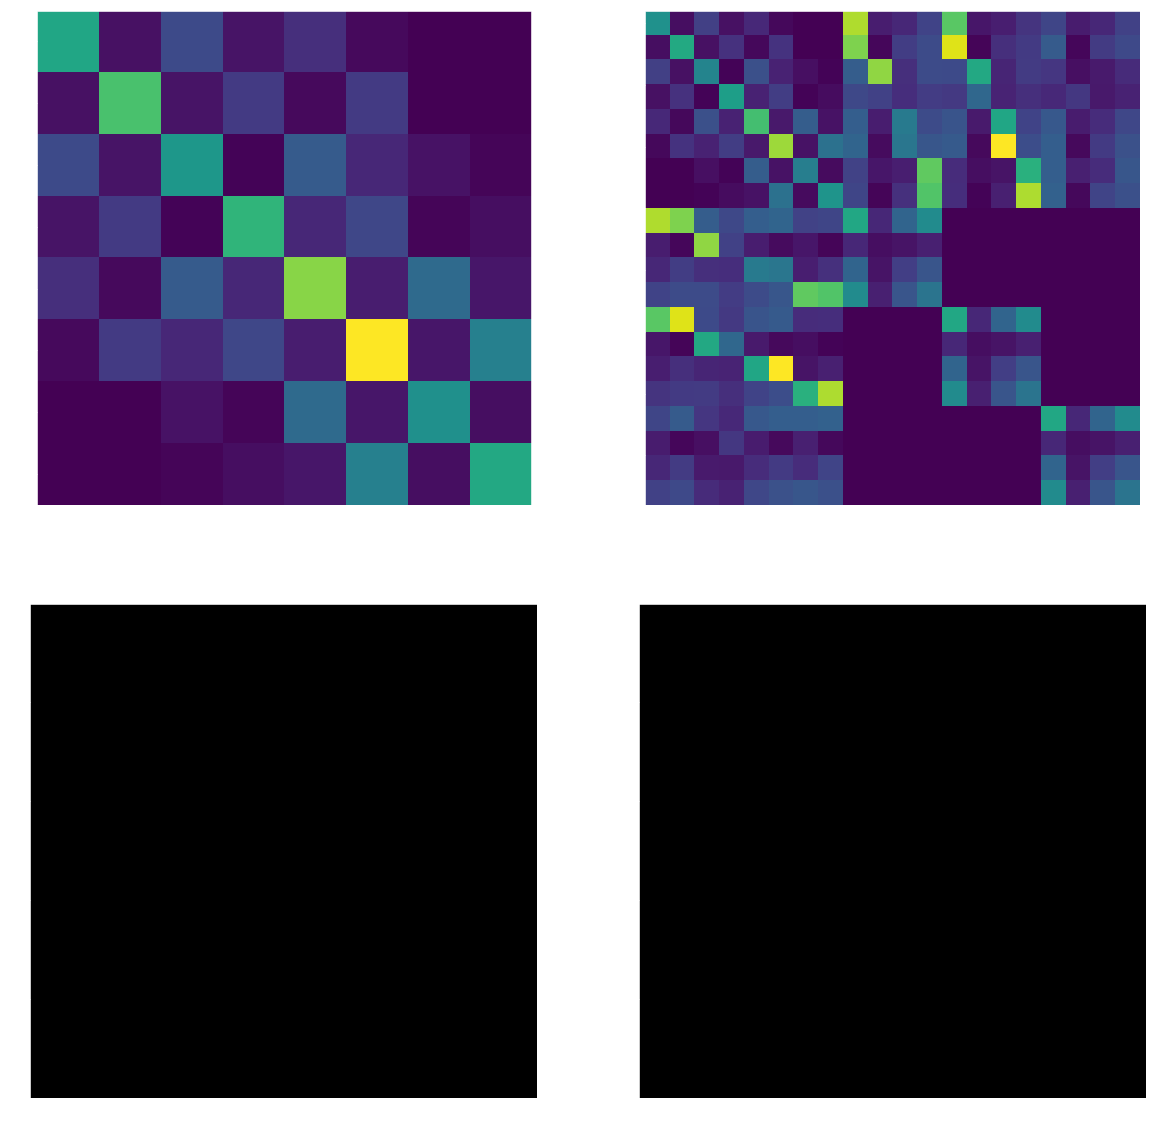

In [38]:
fig, ax = plt.subplots(2,2, figsize=(20, 20))
ax[0,1].imshow(H.abs())
ax[0,0].imshow(get_block(H, model, 0, 0).abs())
#ax[1,0].imshow(h12.abs())
#ax[1,1].imshow(h2.abs())

In [11]:
def H11(model, x):
    """
    """
    with torch.no_grad():
        xx = x.t().mm(x)
        
        w2 = model.out.fc.weight
        ww2 = w2.t().mm(w2)
        
        return kronecker_product(ww2, xx)

In [12]:
#dim = xx.shape[0]
#a = get_block(H, model, 0, 0)[:dim,:dim]
#b = get_block(H, model, 0, 0)[dim:dim*2,dim:dim*2]

In [16]:
xx = x.t().mm(x)
w2 = model.out.fc.weight
ww2 = w2.t().mm(w2)
ww2.shape
act = model.l1.act.last_msk
act.shape

torch.Size([1000, 4])

In [27]:
W = (act[:,None,:] * w2[None,:,:]).sum(0)
WW = W.t().mm(W)

In [33]:
h11 = kronecker_product(WW, xx)
h11.shape

torch.Size([8, 8])

In [34]:
H11 = get_block(H, model, 0, 0)

In [10]:
with torch.no_grad():
    xx = x.t().mm(x)

    act = model.l1.act.last_msk
    act = act.t().mm(act)
    w2 = model.out.fc.weight
    ww2 = w2.t().mm(w2)
 

In [ ]:
shared_dim = hid_dims
Id = torch.eye(out_dim).cuda()

In [14]:
jacob = act.mm(w2.t())
jcov = jacob.t().mm(jacob)

In [9]:
w2

NameError: name 'w2' is not defined

In [18]:
h = kronecker_product(jcov, xx)

In [12]:
xx.shape

torch.Size([7, 7])

In [13]:
w2.shape

torch.Size([3, 10])

In [39]:
w2 = model.out.fc.weight
w2.shape

torch.Size([3, 10])

In [42]:
act.shape

torch.Size([1000, 10])

In [20]:
h.shape

torch.Size([21, 21])

In [19]:
#get_block(H, model, 0, 0) / h

RuntimeError: The size of tensor a (70) must match the size of tensor b (21) at non-singleton dimension 1

In [28]:
get_block(H, model, 1, 1) / h2

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
            nan,    nan,    nan],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
       

In [19]:
#get_block(H, model, 0, 1) / h12